# GoogLeNet

## 1.Import les donées et les modules

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

import os
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split

#### 1.1 Traitement les données

In [ ]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

Afin d'éviter que les données soient trop volumineuses et que le temps d'entraînement soit trop long, nous ne sélectionnons que les 600 premières données pour l'entraînement.

In [ ]:
x_test_temp = x_test
y_test_temp = y_test

x_val = x_train[600:620,:,:]
y_val = y_train[600:620]

x_train = x_train[:600,:,:]
y_train = y_train[:600]

x_test = x_test[:100,:,:]
y_test = y_test[:100]

x_test_temp = x_test_temp[:100,:,:]
y_test_temp = y_test_temp[:100]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(600).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(256)

##2.Modèle GoogleNet

In [ ]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [ ]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']             

In [ ]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=40)

Epoch 1/40
10/10 [==============================] - 19s 493ms/step - loss: 3.6837 - dense_4_loss: 2.3022 - dense_1_loss: 2.3023 - dense_3_loss: 2.3025 - dense_4_accuracy: 0.1150 - dense_1_accuracy: 0.0933 - dense_3_accuracy: 0.0933 - val_loss: 3.6893 - val_dense_4_loss: 2.3041 - val_dense_1_loss: 2.3127 - val_dense_3_loss: 2.3049 - val_dense_4_accuracy: 0.1500 - val_dense_1_accuracy: 0.1500 - val_dense_3_accuracy: 0.1500
Epoch 2/40
10/10 [==============================] - 2s 156ms/step - loss: 3.6756 - dense_4_loss: 2.2967 - dense_1_loss: 2.2957 - dense_3_loss: 2.3007 - dense_4_accuracy: 0.1317 - dense_1_accuracy: 0.1367 - dense_3_accuracy: 0.1317 - val_loss: 3.6690 - val_dense_4_loss: 2.2912 - val_dense_1_loss: 2.2961 - val_dense_3_loss: 2.2963 - val_dense_4_accuracy: 0.1500 - val_dense_1_accuracy: 0.1500 - val_dense_3_accuracy: 0.1500
Epoch 3/40
10/10 [==============================] - 2s 156ms/step - loss: 3.6669 - dense_4_loss: 2.2952 - dense_1_loss: 2.2783 - dense_3_loss: 2.2939 -

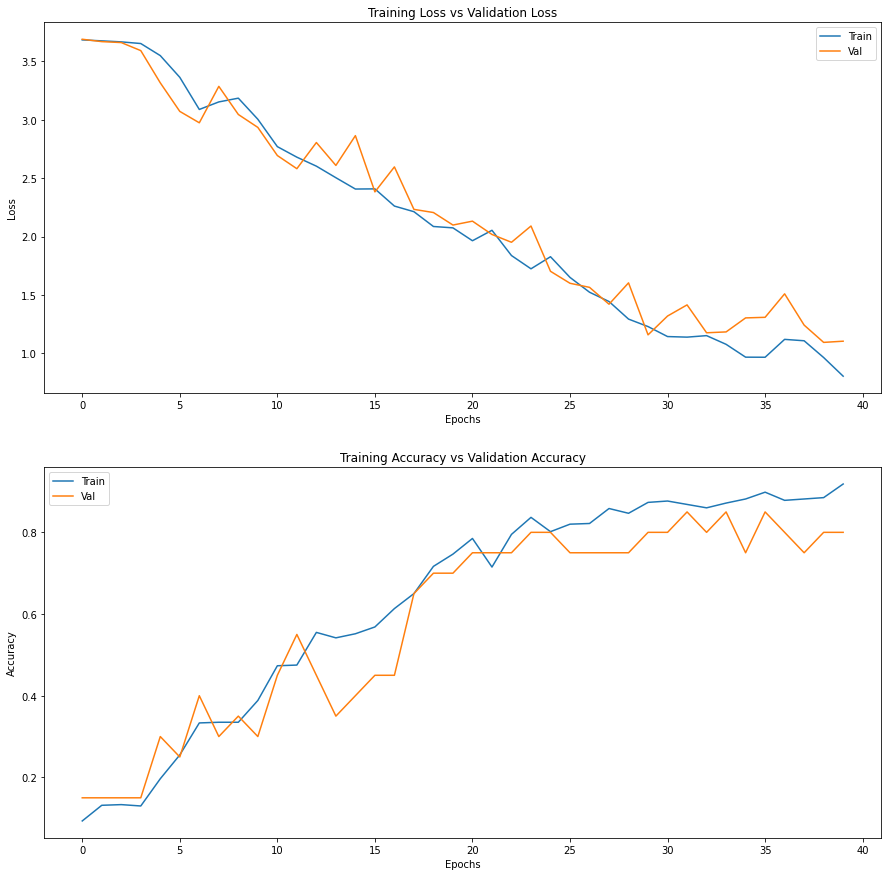

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_3_accuracy'])
axs[1].plot(history.history['val_dense_3_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

##3.Implémentation la méthode FGSM(Fast Gradient Sign Method)
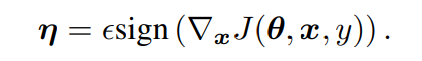

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    #print(prediction[0])
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.int64)
y_test = tf.cast(y_test, tf.int64)

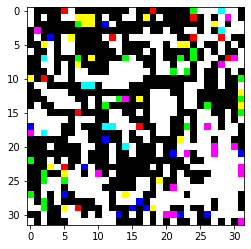

In [ ]:
perturbations = create_adversarial_pattern(x_test, [y_test,y_test,y_test])
plt.imshow(perturbations[0])

## 4.Confiance of résultat avec et sans perturbation

In [ ]:
origine_test = model.predict(x_test) #prédiction

4/4 [==============================] - 2s 192ms/step


In [ ]:
# Fonction normalisation
from matplotlib.pyplot import MultipleLocator
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

[6.2913768e-09 1.9731960e-06 1.1310302e-05 3.7171805e-05 2.5053143e-03
 4.8682687e-06 8.2011647e-06 9.3944776e-01 2.6355237e-05 5.7957012e-02]


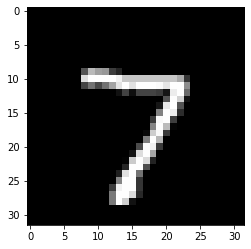

In [ ]:
plt.imshow(x_test[0])
print(origine_test[0][0])

[2.3627387e-01 5.9926399e-05 7.0681441e-01 3.2847172e-03 3.6087788e-06
 8.9409845e-03 5.4328451e-03 2.3225253e-05 3.9151601e-02 1.4788135e-05]


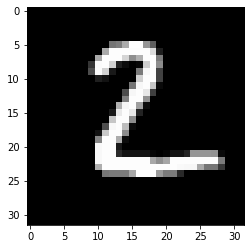

In [ ]:
plt.imshow(x_test[1])
print(origine_test[0][1])

####4.1 Résultat originale

In [ ]:
#normaliser les résultats
res1_nor = normalization(origine_test[0][0])
res2_nor = normalization(origine_test[0][1])

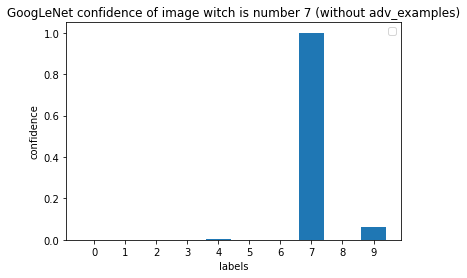

In [ ]:
plt.bar(range(len(res1_nor)), res1_nor)
plt.title('GoogLeNet confidence of image witch is number 7 (without adv_examples)')
plt.xlabel('labels')
plt.ylabel('confidence')
plt.legend()
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()


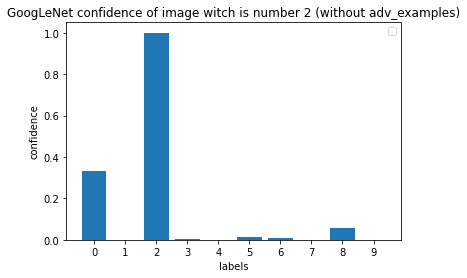

In [ ]:
plt.bar(range(len(res2_nor)), res2_nor)
plt.title('GoogLeNet confidence of image witch is number 2 (without adv_examples)')
plt.xlabel('labels')
plt.ylabel('confidence')
plt.legend()
#plt.grid()
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

####4.2 Résultat avec perturbation

In [ ]:
adv_image = x_test + 0.2*perturbations
adv_test = model.predict(adv_image)

4/4 [==============================] - 0s 48ms/step


[7.96621442e-01 4.23239451e-03 4.52658581e-03 1.30445815e-05
 6.10666489e-03 1.12145244e-05 1.81849971e-01 2.57565733e-03
 4.05856920e-03 4.53891425e-06]


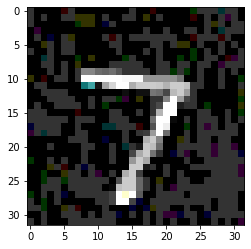

In [ ]:
plt.imshow(adv_image[0])
print(adv_test[0][0])

[9.9887532e-01 2.4528896e-05 9.0233662e-08 4.2056168e-14 7.2014482e-06
 2.6685010e-13 1.0924169e-03 4.3382305e-11 3.4264372e-07 8.6429345e-15]


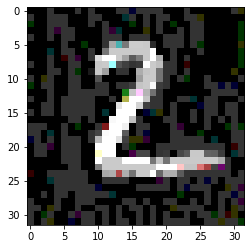

In [ ]:
plt.imshow(adv_image[1])
print(adv_test[0][1])

In [ ]:
adv_res1_nor = normalization(adv_test[0][0])
adv_res2_nor = normalization(adv_test[0][1])

In [ ]:
plt.bar(range(len(adv_res1_nor)), adv_res1_nor)
plt.title('GoogLeNet confidence of image witch is number 7 (with adv_examples)')
plt.xlabel('labels')
plt.ylabel('confidence')
plt.legend()
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

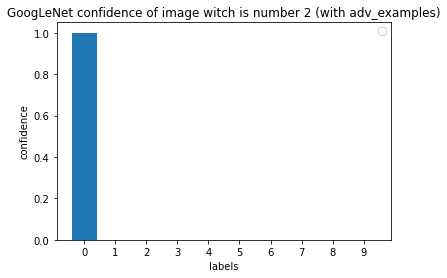

In [ ]:
plt.bar(range(len(adv_res2_nor)), adv_res2_nor)
plt.title('GoogLeNet confidence of image witch is number 2 (with adv_examples)')
plt.xlabel('labels')
plt.ylabel('confidence')
plt.legend()
#plt.grid()
x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.show()

##4. Résultat de l'attaque contradictoire

####4.1 Fonction qui sert à afficher les images

In [ ]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette prédite par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, num = 10):
  fig = plt.figure(figsize=(2*num,3)) 
  for i in range(num):   
      plt.subplot(1,num,i+1) 
      plt.imshow((image[i,:,:]+ 1)/2) 
      plt.title('{} -> {}'.format(label[i],adv_label[i]))
      plt.axis('off') 
  plt.show()

###4.2 Afficher les résultats

epsilons = 0:
4/4 [==============================] - 0s 35ms/step


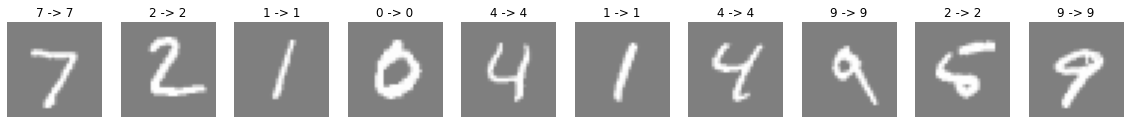

epsilons = 0.05:
4/4 [==============================] - 0s 33ms/step


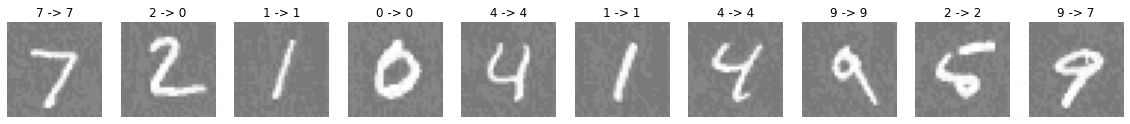

epsilons = 0.1:
4/4 [==============================] - 0s 26ms/step


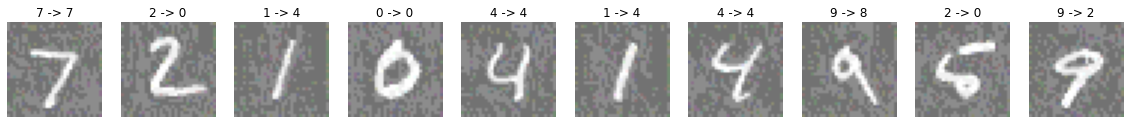

epsilons = 0.15:
4/4 [==============================] - 0s 26ms/step


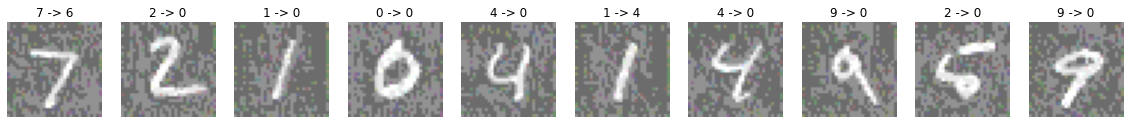

epsilons = 0.2:
4/4 [==============================] - 0s 31ms/step


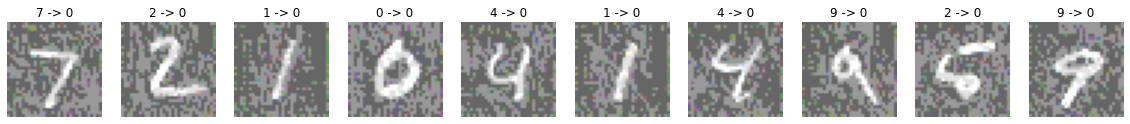

epsilons = 0.25:
4/4 [==============================] - 0s 34ms/step


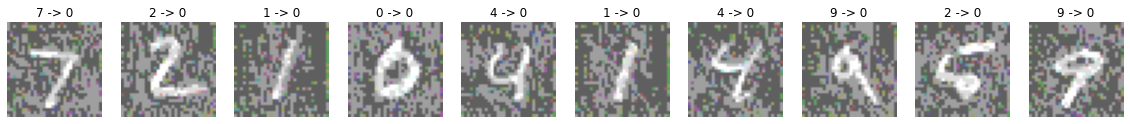

epsilons = 0.3:
4/4 [==============================] - 0s 27ms/step


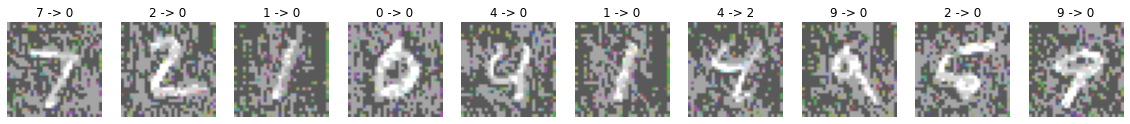

In [ ]:
# Tester dans les différentes valeurs d'epsilon 
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine
  x_test = tf.clip_by_value(x_test, -1, 1)
  predict_label = model.predict(x_test)
  predict_label = np.array([np.argmax(i) for i in predict_label[0]])

  # Générer des adversarial pattern et obtenir des résultats de prédiction 
  adv_image = x_test_temp + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label[0]])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score = model.evaluate(adv_image,y_test,verbose=0)
  adv_acc_list.append(score[-1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, 10)

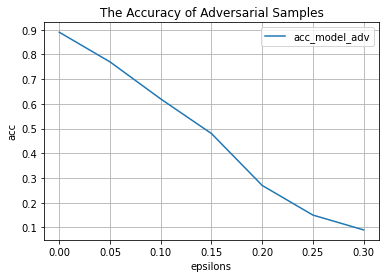

acc [0.8899999856948853, 0.7699999809265137, 0.6200000047683716, 0.47999998927116394, 0.27000001072883606, 0.15000000596046448, 0.09000000357627869]
epsilons [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


In [ ]:
plt.figure()
plt.plot(epsilons,adv_acc_list,label='acc_model_adv')
#plt.plot(epsilons,acc_list,label='acc_model')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',adv_acc_list)
print('epsilons',epsilons)